# Imports

In [1]:
from utils.imports import *
from utils.data_loader import download_data, load_data
from utils.utils import preprocess_images, get_current_time, calculate_pca, apply_pca_to_rois, GaborPyramid
from utils.config import batch_size, num_epochs, model_str

# Initialize data

In [2]:
fnames = ["../kay_labels.npy", "../kay_labels_val.npy", "../kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

if download_data(fnames, urls):
    init_training_inputs, init_test_inputs, training_outputs, test_outputs, roi, roi_names, labels, val_labels = load_data('../kay_images.npz')

# Gabor Wavelet Pyramid

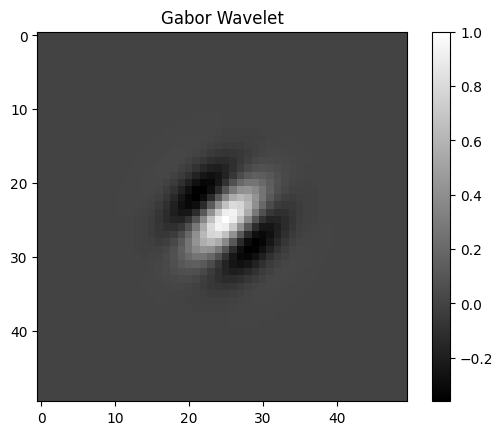

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

def create_gabor_wavelet(spatial_frequency, orientation, phase, image_resolution):
    # Convert orientation to radians
    orientation_rad = orientation * np.pi / 4 

    # Calculate wavelength and phase in radians
    wavelength = image_resolution / spatial_frequency
    phase_rad = phase * (2 * np.pi / 2) 

    # Initialize a grid for the wavelet
    x, y = np.meshgrid(np.arange(image_resolution) - image_resolution // 2,
                       np.arange(image_resolution) - image_resolution // 2)

    # Rotate the grid for the orientation
    xr = x * np.cos(orientation_rad) + y * np.sin(orientation_rad)
    yr = -x * np.sin(orientation_rad) + y * np.cos(orientation_rad)

    # Generate the sinusoidal wave
    sinusoid = np.cos(2 * np.pi * xr / wavelength + phase_rad)

    # Create Gaussian envelope
    sigma = wavelength / np.pi
    gaussian_envelope = np.exp(-(xr**2 + yr**2) / (2 * sigma**2))

    # Create Gabor wavelet by modulating the sinusoid with the Gaussian envelope
    gabor_wavelet = sinusoid * gaussian_envelope

    return gabor_wavelet

spatial_frequency = 4  
orientation = 1        
phase = 0              
image_resolution = 50  

# Create Gabor wavelet
gabor_wavelet = create_gabor_wavelet(spatial_frequency, orientation, phase, image_resolution)

# Plot Gabor wavelet
plt.imshow(gabor_wavelet, cmap='gray')
plt.title("Gabor Wavelet")
plt.colorbar()
plt.show()


In [9]:
import torch
import torch.nn as nn
import numpy as np
from torch.nn.parameter import Parameter

class GaborWaveletPyramid(nn.Module):
    def __init__(self, max_cycles_per_fov, num_orientations, num_phases, image_resolution, output_size=10):
        super(GaborWaveletPyramid, self).__init__()
       
        
        self.max_cycles_per_fov = max_cycles_per_fov
        self.num_orientations = num_orientations
        self.num_phases = num_phases
        self.image_resolution = image_resolution
        self.spatial_frequencies = 2 ** np.arange(np.log2(max_cycles_per_fov))
        
        # Define parameters of the model
        self.num_wavelets = len(self.spatial_frequencies) * num_orientations * num_phases
        self.kernel = Parameter(torch.zeros(self.num_wavelets))  # The weights for each wavelet
        self.dc_offset = Parameter(torch.zeros(1))  # The DC offset

        # Generate Gabor wavelets
        self.gabor_wavelets = self.generate_gabor_wavelets(max_cycles_per_fov, num_orientations, num_phases, image_resolution)

        self.fc = nn.Linear(self.num_wavelets, output_size)
        self.precomputed = None
        
    def generate_gabor_wavelets(self, max_cycles_per_fov, num_orientations, num_phases, image_resolution):
        wavelets = []
        for spatial_frequency in self.spatial_frequencies:
            for orientation in range(num_orientations):
                for phase in range(num_phases):
                    wavelet = create_gabor_wavelet(spatial_frequency, orientation, phase, image_resolution)
                    wavelets.append(torch.tensor(wavelet, dtype=torch.float32))
        return torch.stack(wavelets)

    
    def compute_gabor_responses(self, images):
        """Precompute Gabor responses for a batch of images."""
        with torch.no_grad():
            batch_responses = []
            n = 0
            for image in images:
                n+=1
                print(n, "/", len(images))
                image = image.unsqueeze(0) if image.dim() == 2 else image
                contrast_energy = torch.zeros(image.size(0), self.num_wavelets, device=image.device)
                for i, wavelet in enumerate(self.gabor_wavelets):
                    response = nn.functional.conv2d(image, wavelet.unsqueeze(0).unsqueeze(0), padding='same')
                    energy = response**2
                    contrast_energy[:, i] = energy.view(energy.size(0), -1).sum(dim=1)
                batch_responses.append(contrast_energy.sqrt())
            return torch.cat(batch_responses)
        
    def compute_and_save_gabor_responses(self, images, file_path):
        """Precompute Gabor responses for a batch of images and save to a file."""
        if isinstance(images, np.ndarray):
            images = torch.from_numpy(images)
        responses = self.compute_gabor_responses(images)
        torch.save(responses, file_path)
        print(f"Saved Gabor responses to {file_path}")

    def load_precomputed_gabor_responses(self, file_path):
        """Load precomputed Gabor responses from a file."""
        self.precomputed = torch.load(file_path)
        print(f"Loaded Gabor responses from {file_path}")
        
    def forward(self, image):

        contrast_energy = self.precomputed if self.precomputed is not None else self.compute_gabor_responses(image)

        output = self.fc(contrast_energy)

        return output



In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = torch.from_numpy(inputs).float().unsqueeze(1) 
        self.outputs = torch.from_numpy(outputs).float()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


In [ ]:
import torch
from torch.utils.data import random_split, DataLoader
from copy import deepcopy

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

pca_output, pca = calculate_pca(training_outputs)

full_dataset = MyDataset(init_training_inputs, pca_output)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

def train_model_with_early_stopping(model, train_loader, val_loader, epochs, learning_rate, patience):
    criterion = nn.MSELoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    best_loss = float('inf')
    best_model = None
    epochs_no_improve = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training phase
        print("In epoch")
        model.train()
        running_loss = 0.0
        print("in train loop")
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 
            optimizer.step()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            print("in val loop")
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model = deepcopy(model.state_dict()) 
            epochs_no_improve = 0
            torch.save(best_model, f'../trained_models/gabor/val_model_pca.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
        if (epoch + 1) % 10 == 0:
            # Plot loss curve
            plt.figure(figsize=(10, 5))
            plt.title(f'{model_str} - Encoder Loss')
            plt.plot(train_losses, label="Encoder Loss")
            plt.plot(val_losses, label="Encoder Validation Loss")
            plt.xlabel("Iterations")
            plt.ylabel("Epoch")
            plt.legend()
            plt.show()
    
    # Load the best model
    model.load_state_dict(best_model)
    plot_losses(train_losses, val_losses)
    return model

# Initialize model
gwp_model = GaborWaveletPyramid(max_cycles_per_fov=16, num_orientations=8, num_phases=2, image_resolution=128)

file_path = 'Inputs_saved.pt'

gwp_model.compute_and_save_gabor_responses(init_training_inputs, file_path)

#gwp_model.load_precomputed_gabor_responses(file_path)


# Train model
trained_model = train_model_with_early_stopping(
    gwp_model,
    train_loader,
    val_loader,
    epochs=5000,  # Number of epochs to train for
    learning_rate= 0.001, #0.001,
    patience=10  # Number of epochs to wait for improvement before stopping
)


In [22]:

def predicted_actual_values(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_actual = []
    model.eval()
    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            outputs = model.forward(data)
            all_preds.extend(outputs.cpu().numpy())
            all_actual.extend(targets.cpu().numpy())

    return np.array(all_preds), np.array(all_actual)

# Compute Root Mean Squared Error
def compute_rmse(predictions, actual):
    rmse = mean_squared_error(actual, predictions, squared=False)
    return rmse

# Compute R-squared (Coefficient of Determination)
def compute_r2_score(predictions, actual):
    r2 = r2_score(actual, predictions)
    return r2

# Compute Pearson Correlation Coefficient
def compute_pearson_correlation(predictions, actual):
    # Flatten the predictions and actual arrays in case they have more than one dimension
    predictions_flat = predictions.flatten()
    actual_flat = actual.flatten()
    correlation, _ = pearsonr(predictions_flat, actual_flat)
    return correlation

# Try running trained model on test data
def test_trained_model(model, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    x_test = init_test_inputs
    y_test = test_outputs

    # Create tensor from training inputs and targets
    x_test_tensor, y_test_tensor = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float()
    test_data_tensor = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
    # Create dataloader from tensor
    test_dataloader = torch.utils.data.DataLoader(test_data_tensor, batch_size, shuffle=True)
    
    # Compute accuracy of model predictions
    predicted_results, actual_results = predicted_actual_values(model, test_dataloader)
    print('Predictions:')
    print(predicted_results[0][0:10])
    print('Actual:')
    print(actual_results[0][0:10])

    rmse = compute_rmse(predicted_results, actual_results)
    r2 = compute_r2_score(predicted_results, actual_results)
    pearson_correlation = compute_pearson_correlation(predicted_results, actual_results)
    
    print(f'Achieved RMSE: {rmse:.2f}')
    print(f'R-squared: {r2:.2f}')
    print(f'Pearson Correlation Coefficient: {pearson_correlation:.2f}')

In [ ]:
# Load model
model = GaborWaveletPyramid(max_cycles_per_fov=16, num_orientations=8, num_phases=2, image_resolution=128)

model.compute_and_save_gabor_responses(init_training_inputs[:1], "test_inputs_gabor_responses.pt")
#model.load_precomputed_gabor_responses("All_inputs.pt")

print('Model loaded:', model_str) 
model.load_state_dict(torch.load('../trained_models/gabor/gabor_pca.pth'))

# Test model
test_trained_model(model=model, batch_size=1)